# Customer Segmentation | Clustering | AutoEncoder

Contents:
1. IMPORTING LIBRARIES AND DATASET
1. PERFORM EXPLORATORY DATA ANALYSIS AND DATA CLEANING
1. FIND THE OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD
    * Apply k-Means
1. APPLY PRINCIPAL COMPONENT ANALYSIS AND VISUALIZE THE RESULTS
1. APPLY AUTOENCODERS (PERFORM DIMENSIONALITY REDUCTION USING AUTOENCODERS)
    * Apply K-Means again after obtaining results from encoders
    * Final Observations

Source: [kaggle](https://www.kaggle.com/anantgupt/customer-segmentation-clustering-autoencoder)

## 1. IMPORTING LIBRARIES AND DATASET

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2  # pip install opencv-python
from IPython.display import display
import zipfile

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf  # pip install tensorflow
import tensorflow.keras.backend as K
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [9]:
sales_df = pd.read_csv('../sales_data_sample.csv')

In [12]:
sales_df.head(2)

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER   SALES  \
0        10107               30      95.70                2  2871.0   
1        10121               34      81.35                5  2765.9   

        ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0  2/24/2003 0:00  Shipped       1         2     2003  ...   
1   5/7/2003 0:00  Shipped       2         5     2003  ...   

              ADDRESSLINE1  ADDRESSLINE2   CITY STATE POSTALCODE COUNTRY  \
0  897 Long Airport Avenue           NaN    NYC    NY      10022     USA   
1       59 rue de l'Abbaye           NaN  Reims   NaN      51100  France   

  TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0       NaN              Yu             Kwai    Small  
1      EMEA         Henriot             Paul    Small  

[2 rows x 25 columns]

In [13]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [14]:
# Convert order date to datetime format
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])
# Check the type of data of ORDERDATE
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [15]:
# checking for null values
sales_df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

we have `ADDRESSLINE2`, `STATE`, `POSTALCODE` and `TERRITORY` these columns have null values

In [16]:
# since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them. 
# Country & City would represent the order grographical information.
# Also we can drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis

to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(to_drop, axis=1)
sales_df.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE   STATUS  \
0               30      95.70                2  2871.00 2003-02-24  Shipped   
1               34      81.35                5  2765.90 2003-05-07  Shipped   
2               41      94.74                2  3884.34 2003-07-01  Shipped   
3               45      83.26                6  3746.70 2003-08-25  Shipped   
4               49     100.00               14  5205.27 2003-10-10  Shipped   

   QTR_ID  MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP PRODUCTCODE COUNTRY DEALSIZE  
0       1         2     2003  Motorcycles    95    S10_1678     USA    Small  
1       2         5     2003  Motorcycles    95    S10_1678  France    Small  
2       3         7     2003  Motorcycles    95    S10_1678  France   Medium  
3       3         8     2003  Motorcycles    95    S10_1678     USA   Medium  
4       4        10     2003  Motorcycles    95    S10_1678     USA   Medium

In [18]:
# checking again for null values
sales_df.isnull().sum().sum()

0

## 2. PERFORM EXPLORATORY DATA ANALYSIS AND DATA CLEANING

In [20]:
# number of unique values
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

In [21]:
sales_df.COUNTRY.unique()

array(['USA', 'France', 'Norway', 'Australia', 'Finland', 'Austria', 'UK',
       'Spain', 'Sweden', 'Singapore', 'Canada', 'Japan', 'Italy',
       'Denmark', 'Belgium', 'Philippines', 'Germany', 'Switzerland',
       'Ireland'], dtype=object)

In [22]:
sales_df.COUNTRY.value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

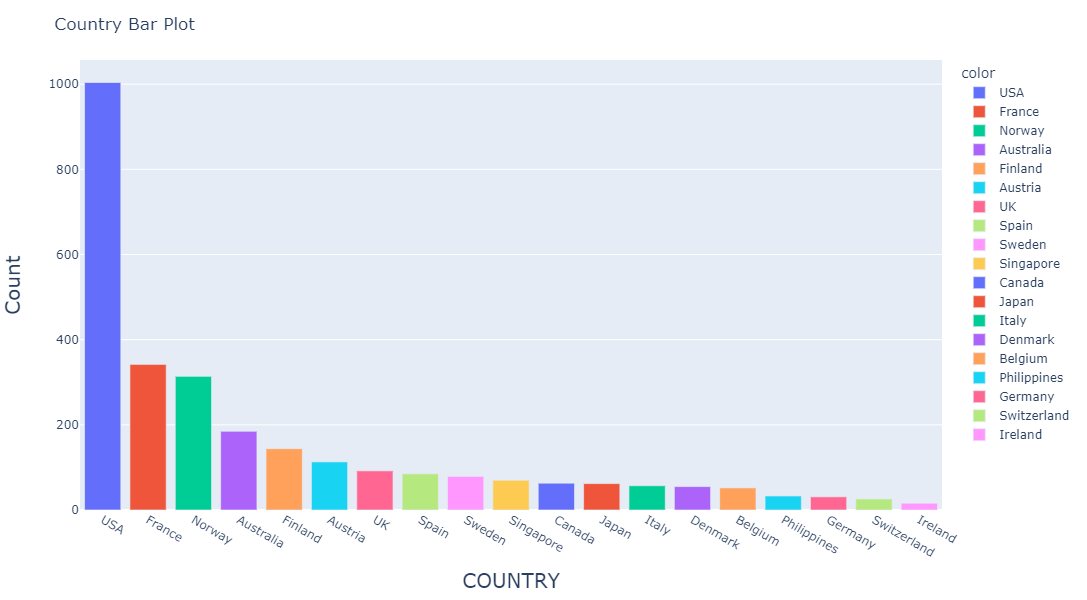

In [23]:
def barplot_visualization(x):
    '''
    Function to visulize the count of items in a given column
    '''
    # fig = plt.figure(figsize=(12,6))
    fig = px.bar(x=sales_df[x].unique(), y=sales_df[x].value_counts(), height=600, color=sales_df[x].unique(),
                 labels={x: x}
                )
    fig.update_layout(yaxis=dict(title_text='Count', titlefont=dict(size=20)),
                      xaxis=dict(title_text=x, titlefont=dict(size=20)),
                      title_text=x[0] + x[1:].lower() + ' Bar Plot'
                      )
    fig.show()


g = barplot_visualization('COUNTRY')

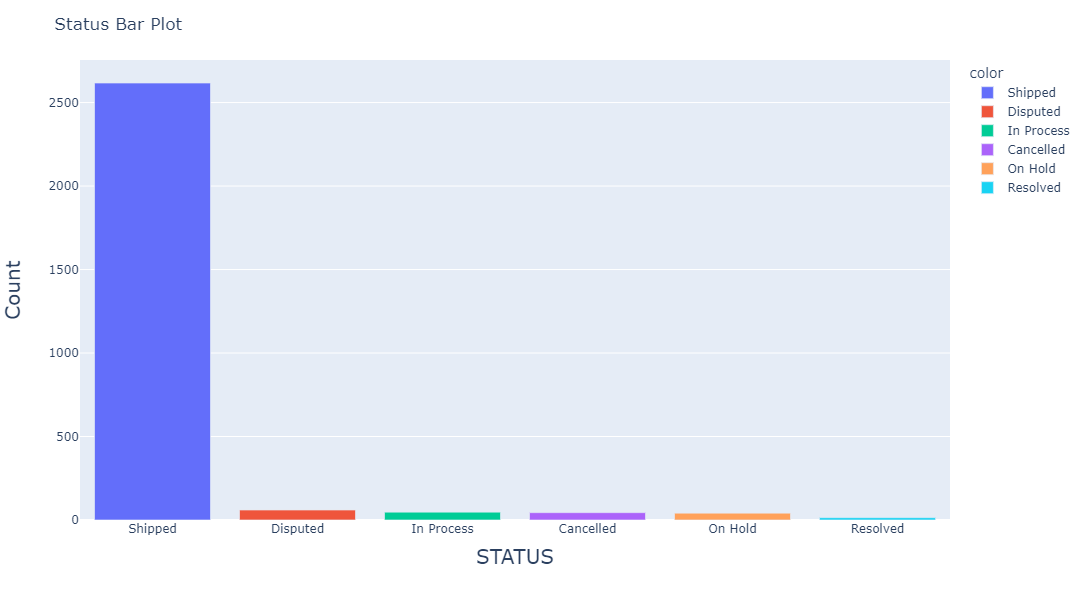

In [24]:
barplot_visualization('STATUS')

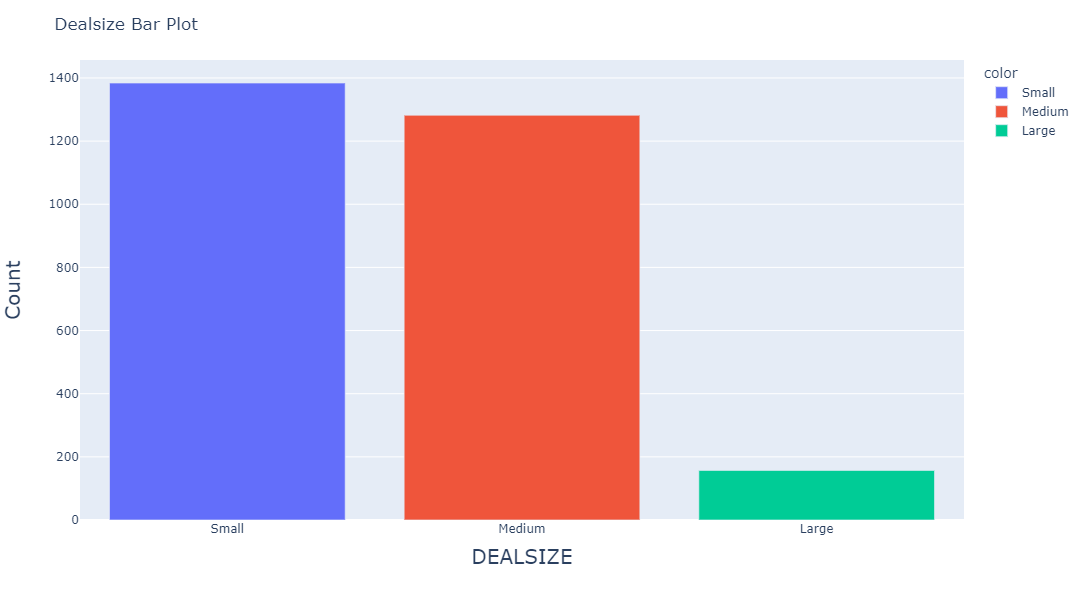

In [25]:
barplot_visualization('DEALSIZE')

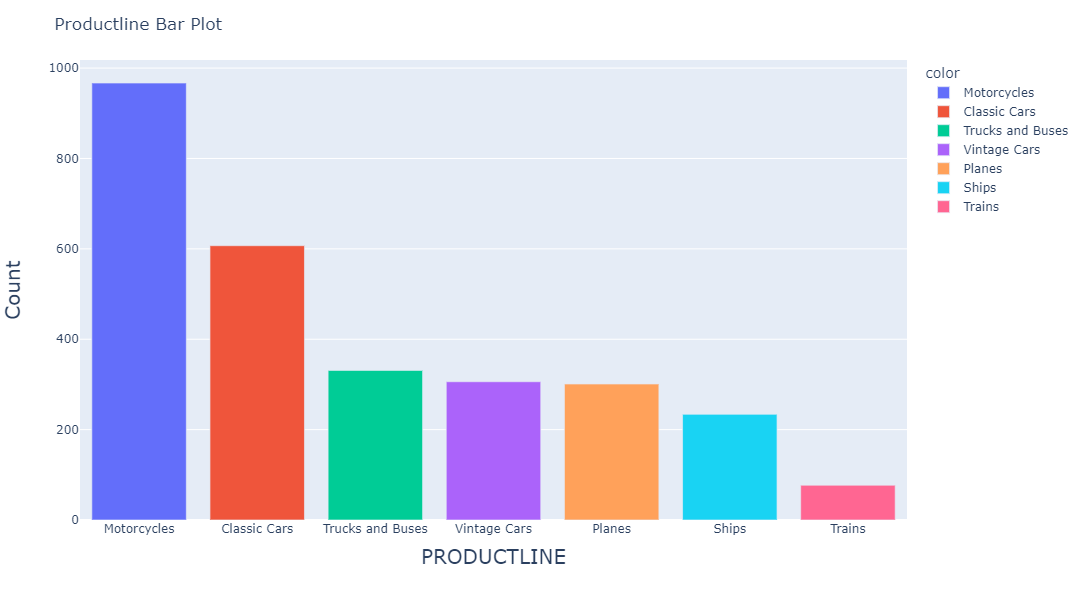

In [26]:
barplot_visualization('PRODUCTLINE')

### Encoding Categorical Variables

In [27]:
status_dict = {'Shipped': 1, 'Cancelled': 2, 'On Hold': 2, 'Disputed': 2, 'In Process': 0, 'Resolved': 0}
sales_df['STATUS'].replace(status_dict, inplace=True)

In [28]:
sales_df = pd.get_dummies(data=sales_df, columns=['PRODUCTLINE', 'DEALSIZE', 'COUNTRY'])
sales_df.shape

(2823, 40)

In [29]:
sales_df.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  STATUS  \
0               30      95.70                2  2871.00 2003-02-24       1   
1               34      81.35                5  2765.90 2003-05-07       1   
2               41      94.74                2  3884.34 2003-07-01       1   
3               45      83.26                6  3746.70 2003-08-25       1   
4               49     100.00               14  5205.27 2003-10-10       1   

   QTR_ID  MONTH_ID  YEAR_ID  MSRP  ... COUNTRY_Italy  COUNTRY_Japan  \
0       1         2     2003    95  ...             0              0   
1       2         5     2003    95  ...             0              0   
2       3         7     2003    95  ...             0              0   
3       3         8     2003    95  ...             0              0   
4       4        10     2003    95  ...             0              0   

   COUNTRY_Norway  COUNTRY_Philippines  COUNTRY_Singapore  COUNTRY_Spain  \
0               0                    0                  0              0   
1               0                    0                  0              0   
2               0                    0                  0              0   
3               0                    0                  0              0   
4               0                    0                  0              0   

   COUNTRY_Sweden  COUNTRY_Switzerland  COUNTRY_UK  COUNTRY_USA  
0               0                    0           0            1  
1               0                    0           0            0  
2               0                    0           0            0  
3               0                    0           0            1  
4               0                    0           0            1  

[5 rows x 40 columns]

In [30]:
pd.Categorical(sales_df['PRODUCTCODE'])

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962', 'S700_4002', 'S72_1253', 'S72_3212']

In [39]:
pd.Categorical(sales_df['PRODUCTCODE']).codes

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

Since the number unique product code is 109, if we add one-hot variables, there would be additional 109 columns, we can avoid that by using categorical encoding. This is not the optimal way of dealing with it but it's important to avoid curse of dimensionality

In [40]:
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [43]:
date_group = sales_df.groupby('ORDERDATE').sum()
date_group

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER     SALES  STATUS  \
ORDERDATE                                                                   
2003-01-06              151     288.78               10  12133.25       4   
2003-01-09              142     284.96               10  11432.34       4   
2003-01-10               80     150.14                3   6864.05       2   
2003-01-29              541    1417.54              136  54702.00      16   
2003-01-31              443    1061.89               91  44621.96      13   
...                     ...        ...              ...       ...     ...   
2005-05-13              259     561.18               21  31821.90      12   
2005-05-17              509    1269.43              105  59475.10      14   
2005-05-29              607    1148.40               94  51233.18       0   
2005-05-30              187     542.16               18  14578.75       0   
2005-05-31              696    1561.40              112  78918.03       0   

            QTR_ID  MONTH_ID  YEAR_ID  MSRP  PRODUCTCODE  ...  COUNTRY_Italy  \
ORDERDATE                                                 ...                  
2003-01-06       4         4     8012   363        174.0  ...              0   
2003-01-09       4         4     8012   372        181.0  ...              0   
2003-01-10       2         2     4006   155         37.0  ...              0   
2003-01-29      16        16    32048  1695        723.0  ...              0   
2003-01-31      13        13    26039  1365        720.0  ...              0   
...            ...       ...      ...   ...          ...  ...            ...   
2005-05-13      12        30    12030   728        101.0  ...              0   
2005-05-17      28        70    28070  1669        462.0  ...              0   
2005-05-29      30        75    30075  1328        797.0  ...              0   
2005-05-30      14        35    14035   618        265.0  ...              0   
2005-05-31      38        95    38095  2065        899.0  ...              0   

            COUNTRY_Japan  COUNTRY_Norway  COUNTRY_Philippines  \
ORDERDATE                                                        
2003-01-06              0               0                    0   
2003-01-09              0               0                    0   
2003-01-10              0               0                    0   
2003-01-29              0              16                    0   
2003-01-31              0               0                    0   
...                   ...             ...                  ...   
2005-05-13              0               0                    0   
2005-05-17              0               0                    0   
2005-05-29              0               0                    0   
2005-05-30              0               0                    0   
2005-05-31              0               0                    0   

            COUNTRY_Singapore  COUNTRY_Spain  COUNTRY_Sweden  \
ORDERDATE                                                      
2003-01-06                  0              0               0   
2003-01-09                  0              0               0   
2003-01-10                  0              0               0   
2003-01-29                  0              0               0   
2003-01-31                  0             13               0   
...                       ...            ...             ...   
2005-05-13                  0              6               0   
2005-05-17                  0              0               0   
2005-05-29                  0              0               0   
2005-05-30                  0              0               0   
2005-05-31                  0              6               0   

            COUNTRY_Switzerland  COUNTRY_UK  COUNTRY_USA  
ORDERDATE                                                 
2003-01-06                    0           0            4  
2003-01-09                    0           0            0  
2003-01-10                    0          

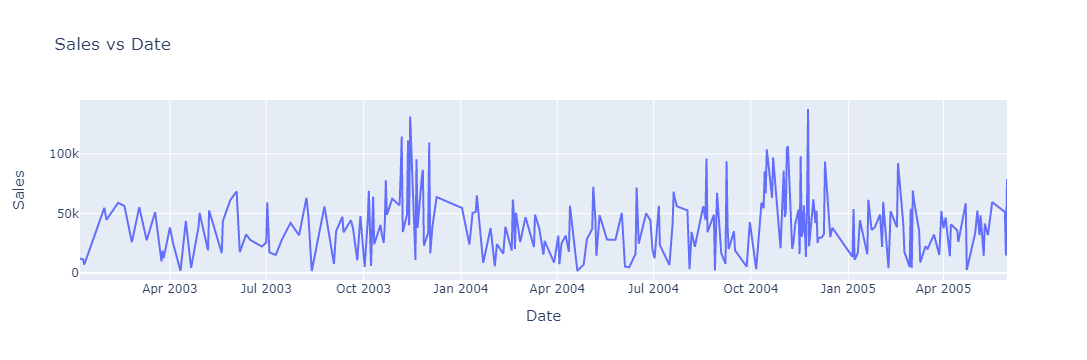

In [44]:
fig = px.line(x = date_group.index, y = date_group.SALES, title = 'Sales vs Date')
fig.update_layout(yaxis=dict(title_text='Sales', titlefont=dict(size=15)), 
                  xaxis=dict(title_text='Date', titlefont=dict(size=15))
                 )
fig.show()

In [45]:
# We can drop 'ORDERDATE' and keep the rest of the date-related data such as 'MONTH'
sales_df.drop("ORDERDATE", axis=1, inplace=True)
sales_df.shape

(2823, 39)

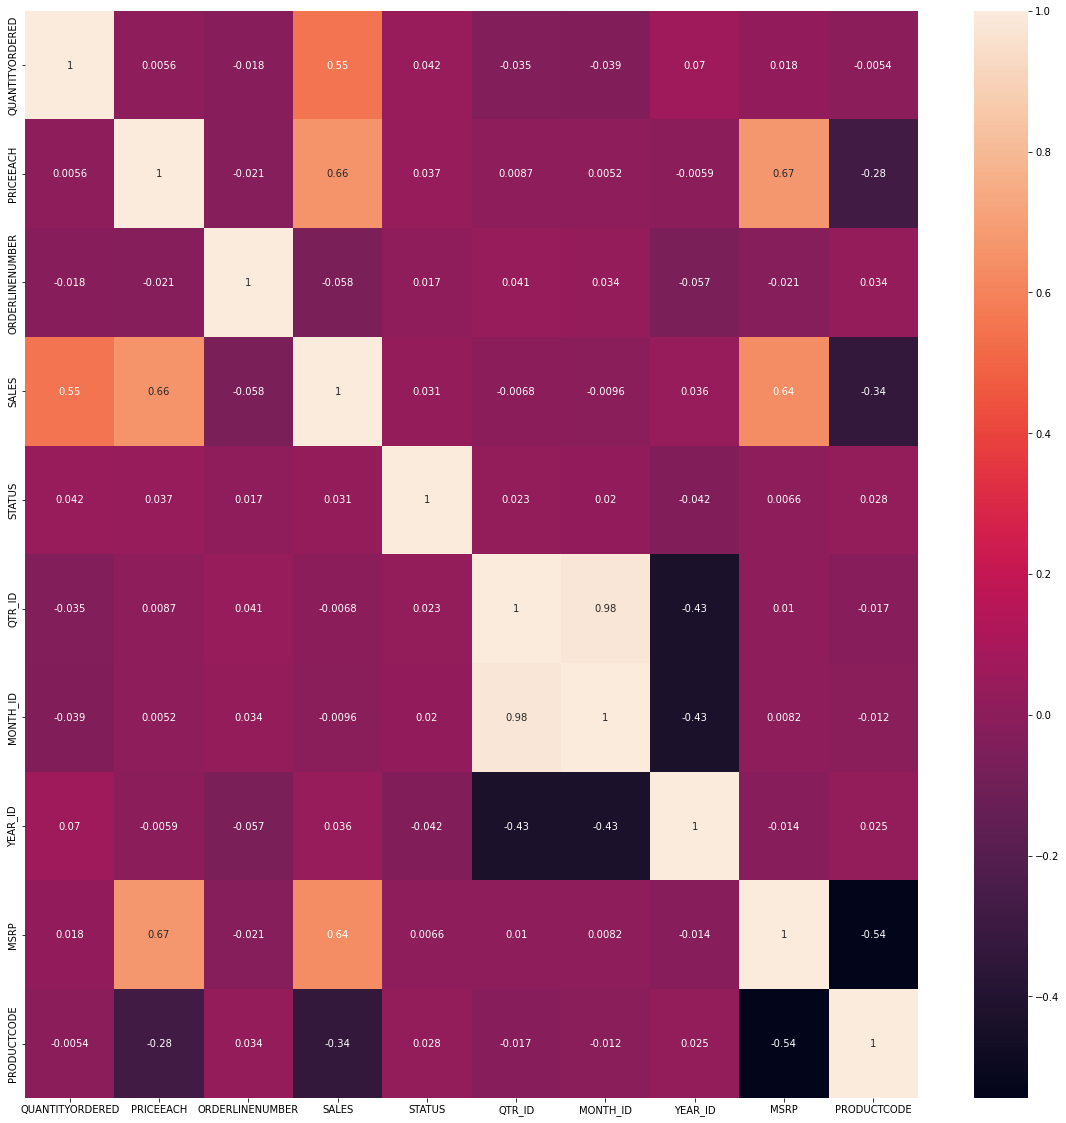

In [48]:
plt.figure(figsize = (20, 20))
corr_matrix = sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot=True);

### OBESRVATIONS (Heatmap)

* There is a high co-relation in Quarter ID and the monthly IDs
* MSRP is +velly correlated to PRICEEACH and SALES
* PRODUCTCODE is -velly correlated with MSRP, PRICEEACH and SALES
* +ve correlation btw SALES, PRICEEACH, QUANTITYORDERED

In [52]:
# It looks like the Quarter ID and the monthly IDs are highly correlated as they will produce nearly same results
# Let's drop 'QTR_ID' (or 'MONTH_ID')
sales_df.drop("QTR_ID", axis=1, inplace=True)
sales_df.shape

(2823, 38)

In [53]:
import plotly.figure_factory as ff

Distplot shows the (1) histogram, (2) kde plot and (3) rug plot.
1. Histogram: it's a graphical display of data using bars with various heights. Each bar groups numbers into ranges and taller bars show that more data falls in that range.
2. Kde Plot: Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable.
3. Rug plot: plot of data for a single quantitative variable, displayed as marks along an axis (one-dimensional scatter plot). 

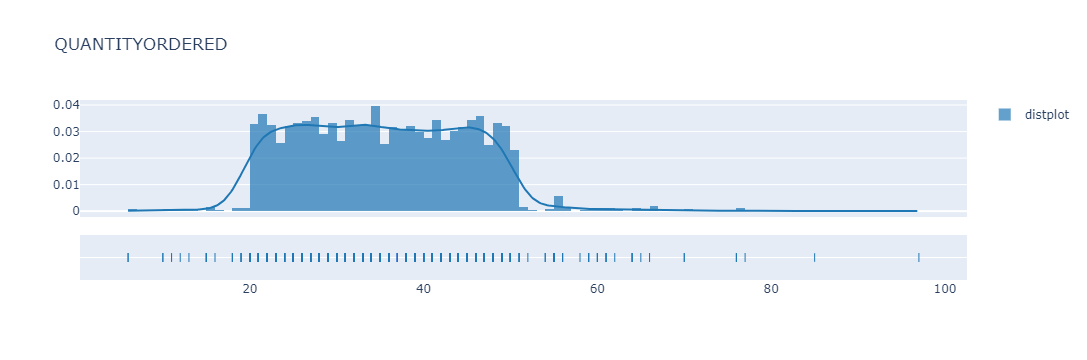

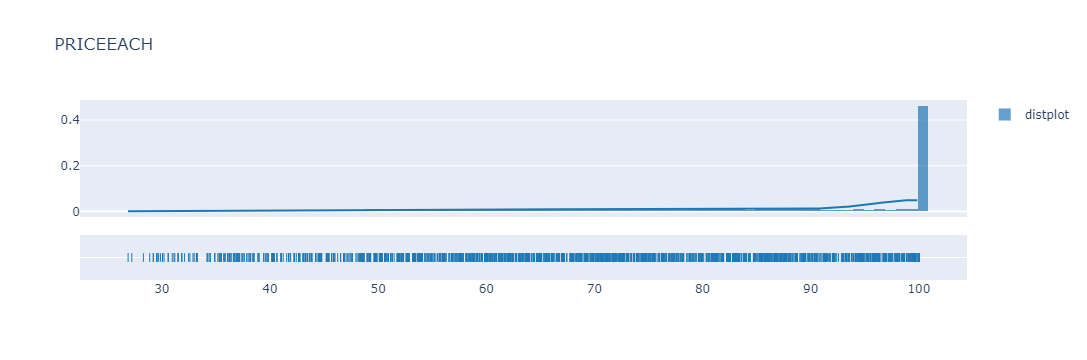

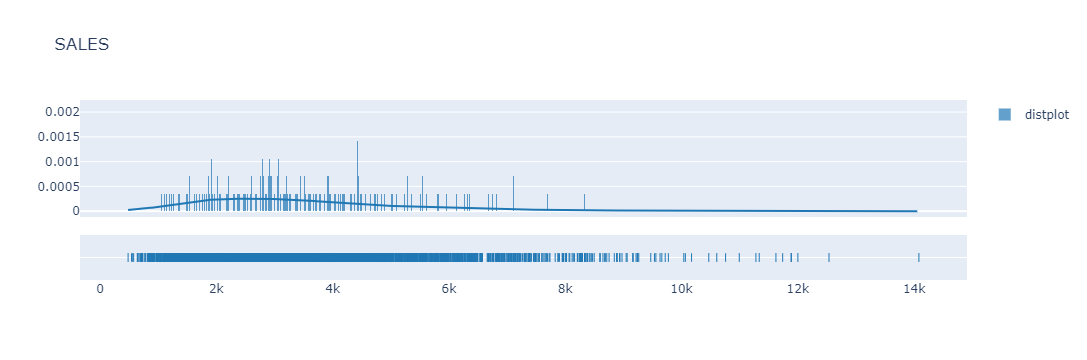

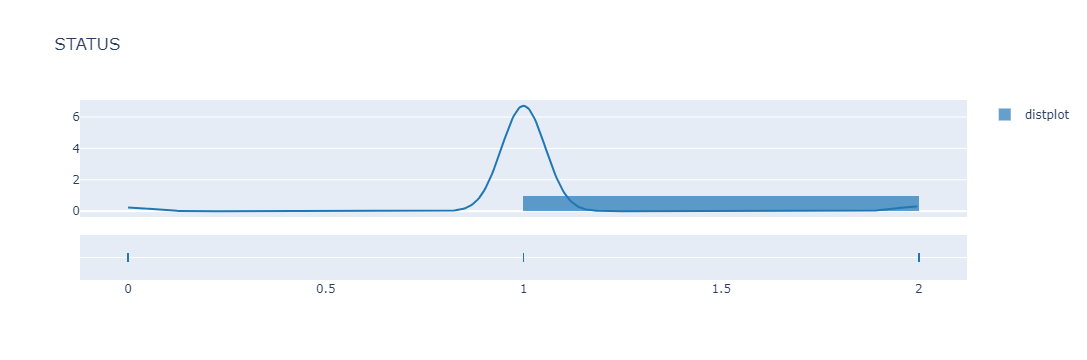

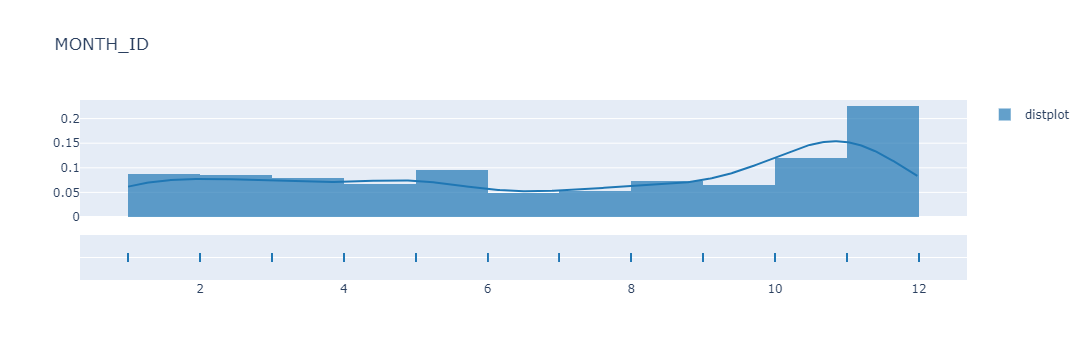

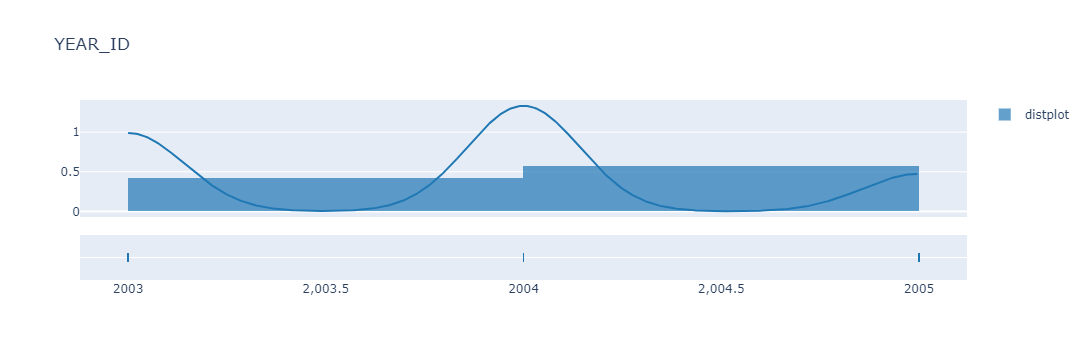

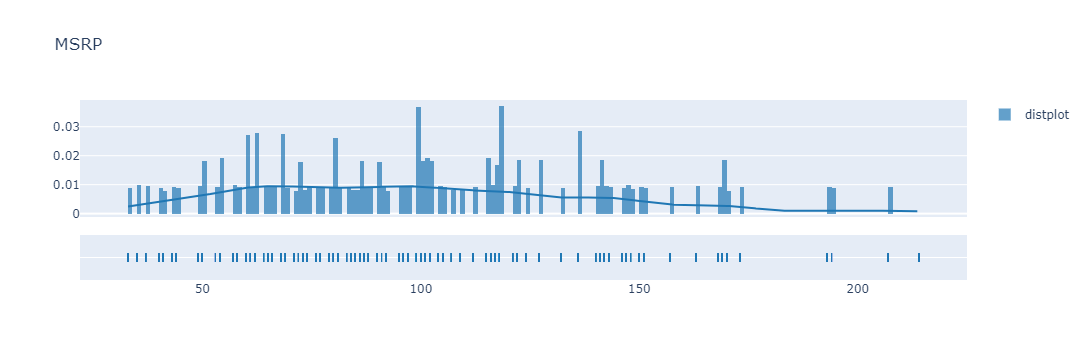

In [54]:
# fig = plt.figure(figsize=(10,10));
for i in range(8):
    if sales_df.columns[i] != 'ORDERLINENUMBER':
        fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot']);
        fig.update_layout(title_text=sales_df.columns[i]);
        fig.show();

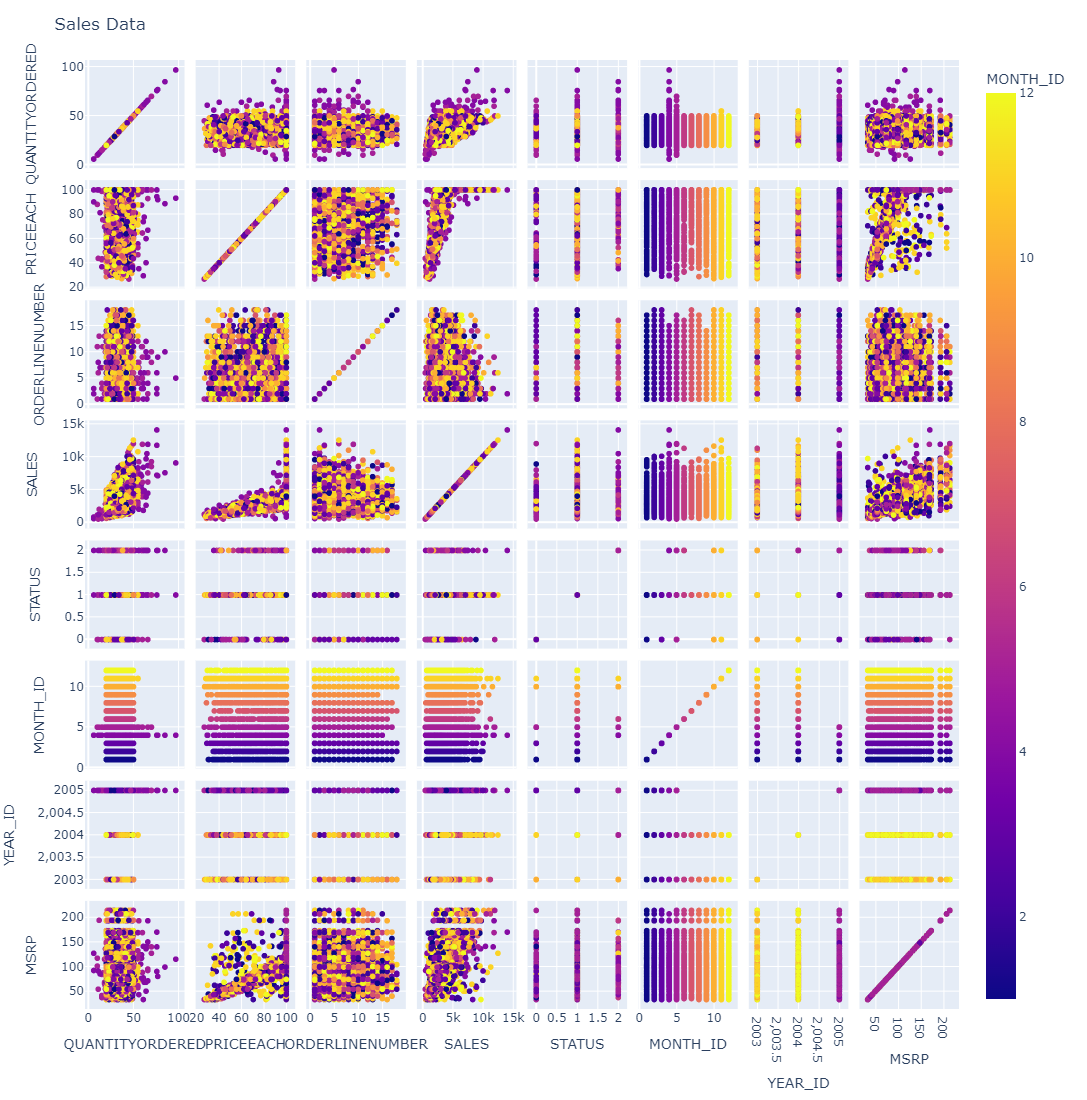

In [55]:
# Visualize the relationship between variables using pairplots

fig = px.scatter_matrix(sales_df,
                        dimensions=sales_df.columns[:8], 
                        color='MONTH_ID')  # fill color by months
fig.update_layout(title_text='Sales Data',
                  width=1100,
                  height=1100
                  )
fig.show()

### OBESRVATIONS (Scattermatrix)
* A trend exists between 'SALES' and 'QUANTITYORDERED'
* A trend exists between 'MSRP' and 'PRICEEACH' (there are some outlaiers)
* A trend exists between 'PRICEEACH' and 'SALES'
* It seems that sales growth exists as we move from 2013 to 2014 to 2015 ('SALES' vs. 'YEAR_ID')

## 3. FIND THE OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD

In [56]:
# Scale the data
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

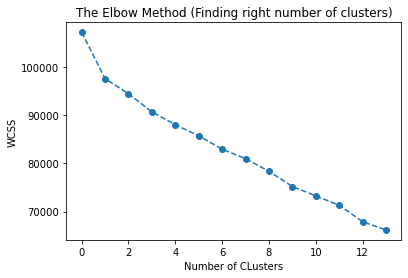

In [58]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(sales_df_scaled)
    wcss.append(kmeans.inertia_)  # intertia is the Sum of squared distances of samples to their closest cluster center (WCSS)

plt.plot(wcss, marker='o', linestyle='--')
plt.title('The Elbow Method (Finding right number of clusters)')
plt.xlabel('Number of CLusters')
plt.ylabel('WCSS')
plt.show()

From this we can observe that, 5th cluster seems to be forming the elbow of the curve. after that we will apply auto encoders to solve this problem

In [59]:
# applying k-means with 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_
labels

array([0, 0, 2, ..., 4, 4, 4])

In [65]:
kmeans.cluster_centers_.shape

(5, 38)

In [66]:
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=sales_df.columns)
cluster_centers

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER     SALES    STATUS  MONTH_ID  \
0        -0.459396  -0.776833         0.037814 -0.825764 -0.032406  0.007359   
1        -0.173109  -0.043239        -0.002022 -0.189407 -0.227747  0.076703   
2         0.278074   0.590928        -0.013239  0.478466  0.010358  0.003395   
3         1.245428   0.800220        -0.259579  2.573861  0.102212 -0.088008   
4        -0.032443   0.017948         0.071494 -0.267337  0.199133 -0.049941   

    YEAR_ID      MSRP  PRODUCTCODE  PRODUCTLINE_Classic Cars  ...  \
0  0.003686 -0.593776     0.200716                 -0.094005  ...   
1 -0.010265 -0.071239    -0.143816                 -0.114649  ...   
2 -0.019893  0.423256    -0.262884                  0.165622  ...   
3  0.136857  1.430265    -0.871802                  0.580097  ...   
4  0.000515 -0.363456     1.124999                 -0.721812  ...   

   COUNTRY_Italy  COUNTRY_Japan  COUNTRY_Norway  COUNTRY_Philippines  \
0       0.078677       0.051730        0.032796             0.011811   
1      -0.204199      -0.136988       -0.176195            -0.096414   
2      -0.028733      -0.030925        0.029991             0.026536   
3       0.023250       0.005118        0.010166            -0.029737   
4      -0.072834       0.022601       -0.176195            -0.096414   

   COUNTRY_Singapore  COUNTRY_Spain  COUNTRY_Sweden  COUNTRY_Switzerland  \
0           0.035471       0.008926       -0.009913            -0.024206   
1          -0.169676      -0.371278       -0.143553            -0.105371   
2           0.008355       0.024661        0.005559             0.071729   
3          -0.015199      -0.039435       -0.052984            -0.105371   
4          -0.065586       0.141693        0.161582            -0.105371   

   COUNTRY_UK  COUNTRY_USA  
0    0.011644     0.030605  
1   -0.231843    -0.742934  
2   -0.003063     0.091243  
3   -0.116045     0.108611  
4    0.216814    -0.115353  

[5 rows x 38 columns]

In [67]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers, columns=sales_df.columns)
cluster_centers

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER        SALES    STATUS  \
0        30.618421  67.989286         6.625940  2033.212961  1.001880   
1        33.406780  82.786384         6.457627  3205.088475  0.949153   
2        37.801174  95.577987         6.410235  4435.002156  1.013423   
3        47.222930  99.799554         5.369427  8293.753248  1.038217   
4        34.776824  84.020558         6.768240  3061.578412  1.064378   

   MONTH_ID      YEAR_ID        MSRP  PRODUCTCODE  PRODUCTLINE_Classic Cars  \
0  7.119361  2003.817669   76.857143    60.111842              2.979323e-01   
1  7.372881  2003.807910   97.853107    49.231638              2.881356e-01   
2  7.104866  2003.801174  117.722315    45.471477              4.211409e-01   
3  6.770701  2003.910828  158.184713    26.242038              6.178344e-01   
4  6.909871  2003.815451   86.111588    89.300429             -5.551115e-17   

   ...  COUNTRY_Italy  COUNTRY_Japan  COUNTRY_Norway  COUNTRY_Philippines  \
0  ...   5.545113e-02   2.537594e-02    3.571429e-02         1.033835e-02   
1  ...   2.081668e-17  -1.040834e-17   -6.938894e-18        -3.469447e-18   
2  ...   3.439597e-02   1.426174e-02    3.523490e-02         1.174497e-02   
3  ...   4.458599e-02   1.910828e-02    3.184713e-02         6.369427e-03   
4  ...   2.575107e-02   2.145923e-02    4.510281e-17        -6.938894e-18   

   COUNTRY_Singapore  COUNTRY_Spain  COUNTRY_Sweden  COUNTRY_Switzerland  \
0       3.383459e-02   1.240602e-01    1.879699e-02         8.458647e-03   
1      -1.040834e-17   2.775558e-17    6.938894e-18        -1.734723e-18   
2       2.936242e-02   1.291946e-01    2.097315e-02         1.845638e-02   
3       2.547771e-02   1.082803e-01    1.273885e-02         0.000000e+00   
4       1.716738e-02   1.673820e-01    4.291845e-02         6.938894e-18   

     COUNTRY_UK   COUNTRY_USA  
0  5.357143e-02  3.703008e-01  
1 -6.938894e-18  5.551115e-17  
2  5.033557e-02  3.993289e-01  
3  2.547771e-02  4.076433e-01  
4  9.871245e-02  3.004292e-01  

[5 rows x 38 columns]

In [68]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

In [69]:
# Add a label (which cluster) corresponding to each data point
sales_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster': labels})], axis=1)
sales_df_cluster

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  STATUS  MONTH_ID  \
0                  30      95.70              2.0  2871.00       1         2   
1                  34      81.35              5.0  2765.90       1         5   
2                  41      94.74              2.0  3884.34       1         7   
3                  45      83.26              6.0  3746.70       1         8   
4                  49     100.00             14.0  5205.27       1        10   
...               ...        ...              ...      ...     ...       ...   
2818               20     100.00             15.0  2244.40       1        12   
2819               29     100.00              1.0  3978.51       1         1   
2820               43     100.00              4.0  5417.57       0         3   
2821               34      62.24              1.0  2116.16       1         3   
2822               47      65.52              9.0  3079.44       2         5   

      YEAR_ID  MSRP  PRODUCTCODE  PRODUCTLINE_Classic Cars  ...  \
0        2003    95            0                         0  ...   
1        2003    95            0                         0  ...   
2        2003    95            0                         0  ...   
3        2003    95            0                         0  ...   
4        2003    95            0                         0  ...   
...       ...   ...          ...                       ...  ...   
2818     2004    54          108                         0  ...   
2819     2005    54          108                         0  ...   
2820     2005    54          108                         0  ...   
2821     2005    54          108                         0  ...   
2822     2005    54          108                         0  ...   

      COUNTRY_Japan  COUNTRY_Norway  COUNTRY_Philippines  COUNTRY_Singapore  \
0                 0               0                    0                  0   
1                 0               0                    0                  0   
2                 0               0                    0                  0   
3                 0               0                    0                  0   
4                 0               0                    0                  0   
...             ...             ...                  ...                ...   
2818              0               0                    0                  0   
2819              0               0                    0                  0   
2820              0               0                    0                  0   
2821              0               0                    0                  0   
2822              0               0                    0                  0   

      COUNTRY_Spain  COUNTRY_Sweden  COUNTRY_Switzerland  COUNTRY_UK  \
0                 0               0                    0           0   
1                 0               0                    0           0   
2                 0               0                    0           0   
3                 0               0                    0           0   
4                 0               0                    0           0   
...             ...             ...                  ...         ...   
2818              1               0                    0           0   
2819              0               0                    0           0   
2820              1               0                    0           0   
2821              0               0                    0           0   
2822              0               0                    0           0   

      COUNTRY_USA  cluster  
0               1        0  
1               0        0  
2               0        2  
3               1        2  
4               1        2  
...           ...      ...  
2818            0        4  
2819            0        4  
2820            0        4  
2821            0        4  
2822            1        4  

[2823 rows x 39 columns]

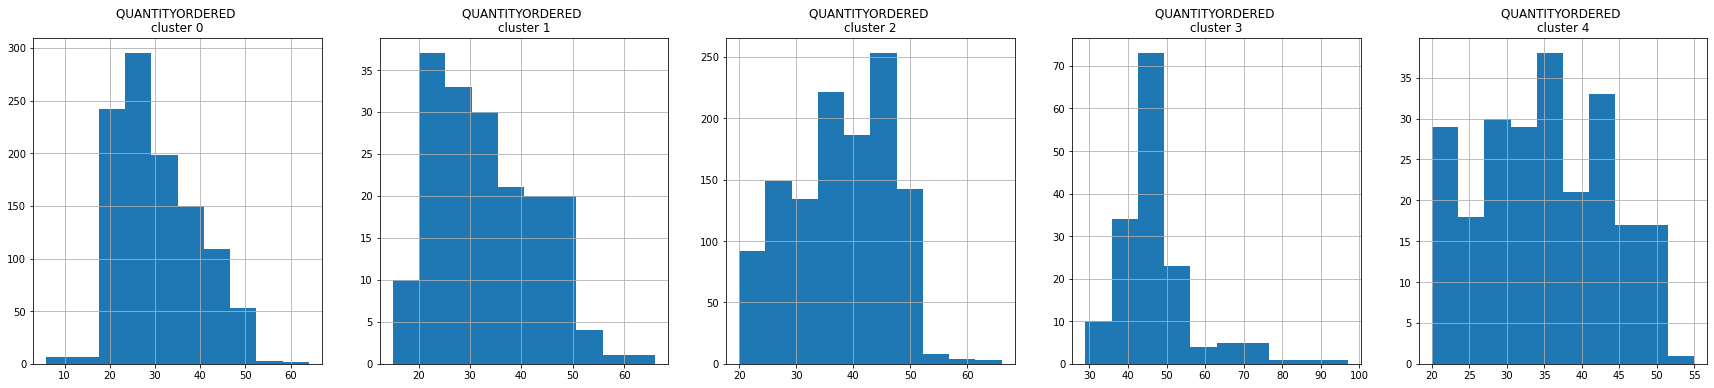

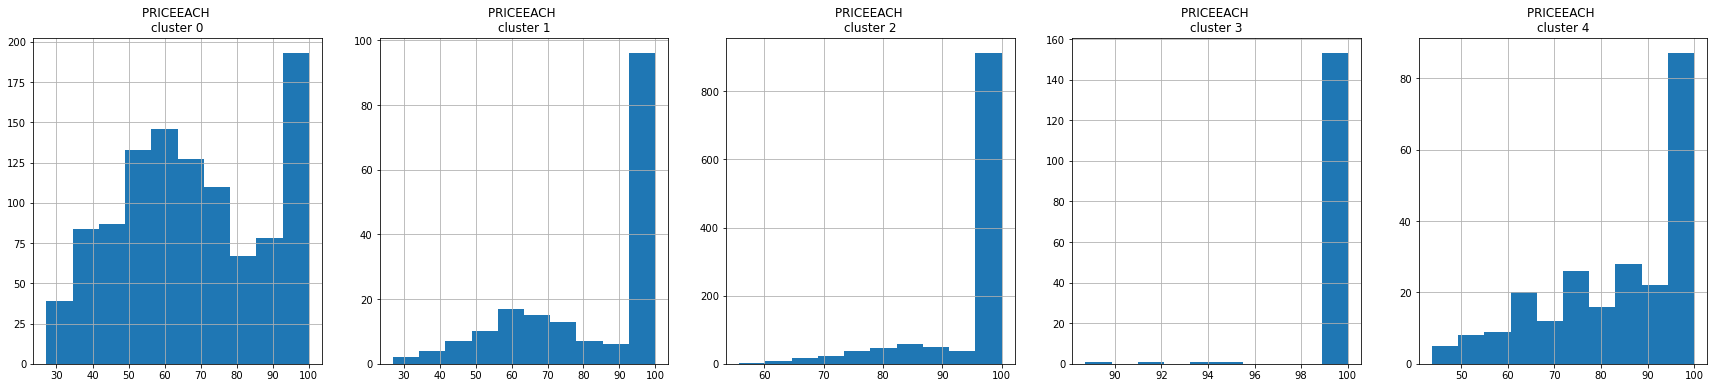

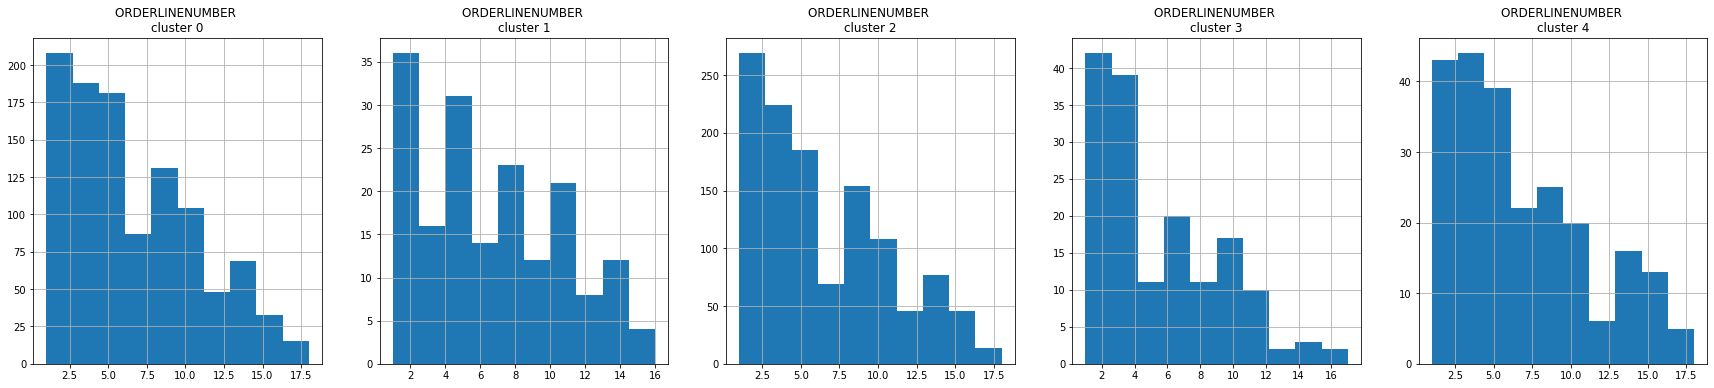

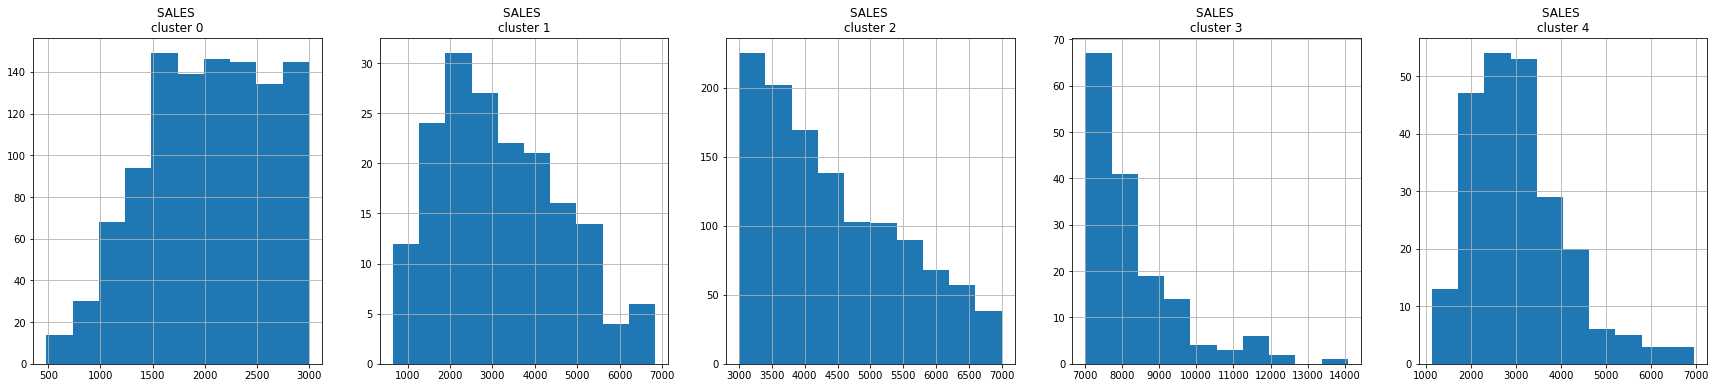

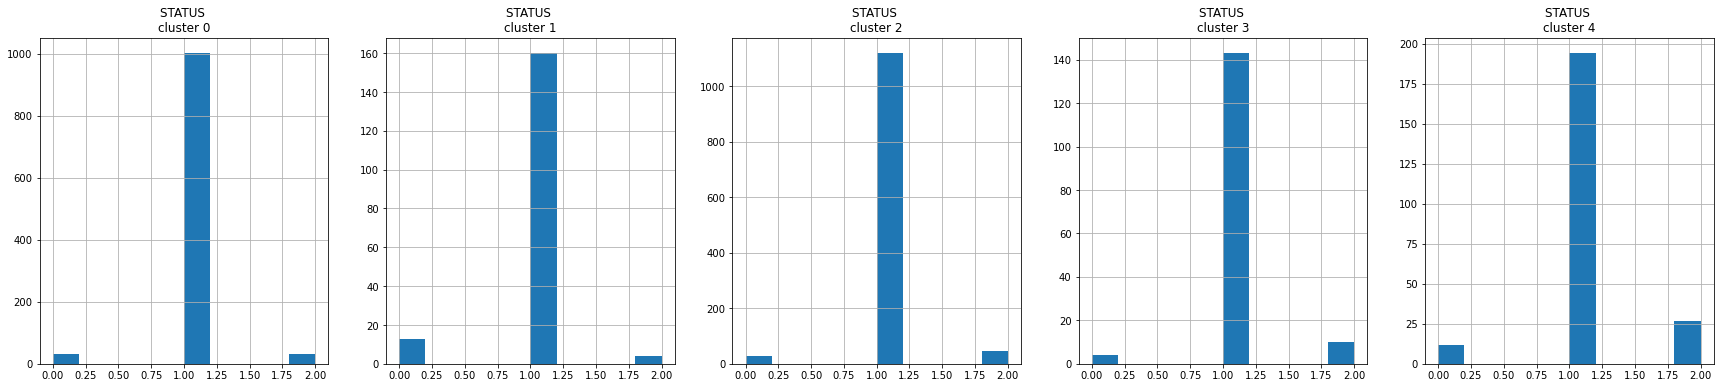

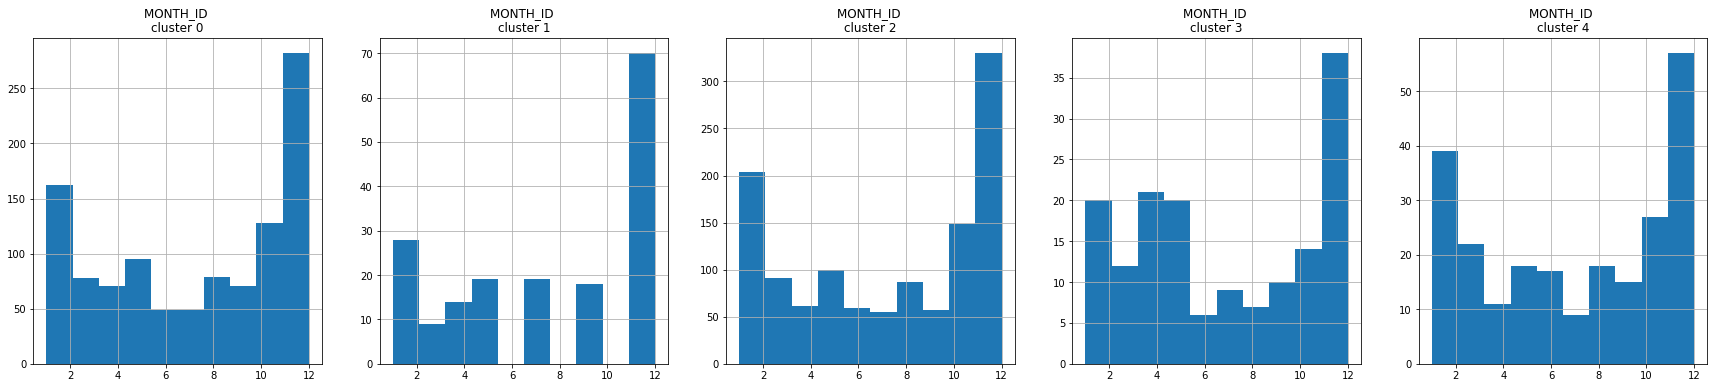

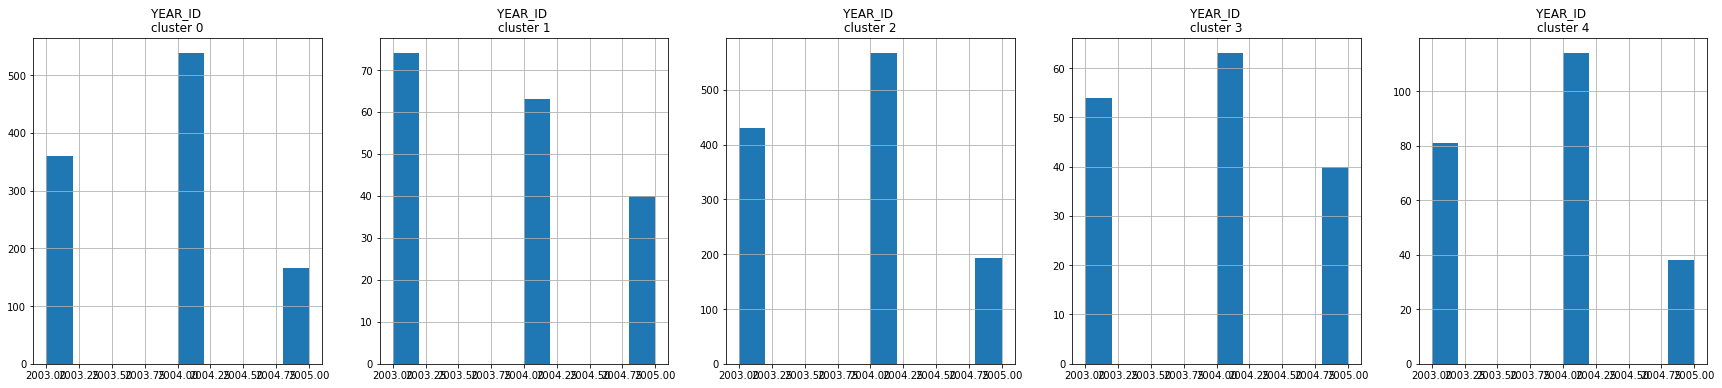

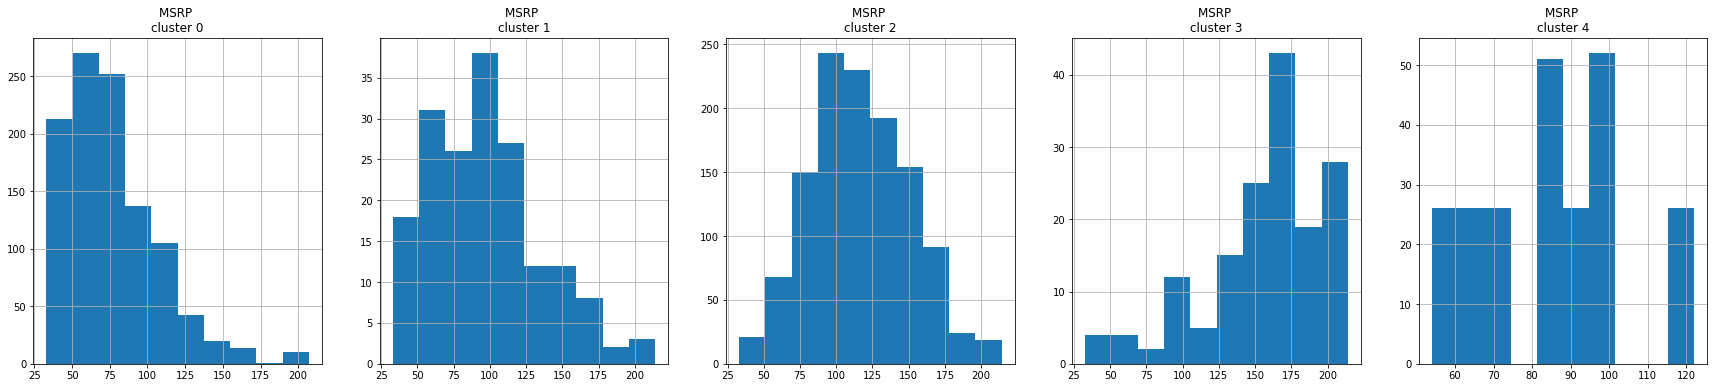

In [70]:
# plot histogram for each feature based on cluster 
for i in sales_df.columns[:8]:
    plt.figure(figsize=(30, 6))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        cluster = sales_df_cluster[sales_df_cluster['cluster']==j]
        cluster[i].hist()
        plt.title('{} \ncluster {}'.format(i,j))
plt.show()

OBERSVATIONS:
* `CLUSTER 0` (highest) - customer in this group buy item in high quantity, price of each item ~ 99, they also corresponds to highest total sales of ~ 8293. They are the highest buyers of products with high MSRP ~158.
* `CLUSTER 1` - This cluster is nearly close to cluster 4 with MSRP around 94 and average quantity ordered ~34, average piced ~ 83 and sales to 3169
* `CLUSTER 2` (lowest) - This group represents customers who buy items in varying quantity ~30, they tend to low price items ~68. Their sales is ~ 2061, they buy products with lowert MSRP of ~62.
* `CLUSTER 3` - This is the second highest cluster, this group buy in medium quantity ~38, wwith total sales upto ~ 4405 with average price of ~ 95. The MSRP is around 115
* `CLUSTER 4` - This group represents customers who are only active during the holidays. they buy in lower quantity ~35, but they tend to buy average price items around ~87. They also correspond to lower total sales around ~3797, they tend to buy items with MSRP around 116.

> NOTE: the KMeans result in the final (save version run) might be different with cluster number and values, but the obervations will be simillar

## 4. APPLY PRINCIPAL COMPONENT ANALYSIS AND VISUALIZE THE RESULTS

In [92]:
pca = PCA(n_components=3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48644432, -1.18808698,  0.74541543],
       [-0.78641875, -1.10233078,  1.43568374],
       [ 1.4298544 ,  0.0756431 ,  0.35961832],
       ...,
       [ 0.33942124,  4.01373468,  0.48270765],
       [-2.78954602,  2.34206826,  1.63951534],
       [-0.65310295,  3.51617873, -1.10747023]])

In [93]:
pca_df = pd.DataFrame(data=principal_comp, columns=['pca1', 'pca2', 'pca3'])
pca_df.head()

pca1      pca2      pca3
0 -0.486444 -1.188087  0.745415
1 -0.786419 -1.102331  1.435684
2  1.429854  0.075643  0.359618
3  1.288818 -0.185188 -0.809287
4  1.976713 -0.109245 -1.253130

In [94]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis=1)
pca_df.head()

pca1      pca2      pca3  cluster
0 -0.486444 -1.188087  0.745415        0
1 -0.786419 -1.102331  1.435684        0
2  1.429854  0.075643  0.359618        2
3  1.288818 -0.185188 -0.809287        2
4  1.976713 -0.109245 -1.253130        2

In [95]:
pca_df.iloc[:, 3].unique()

array([0, 2, 1, 3, 4])

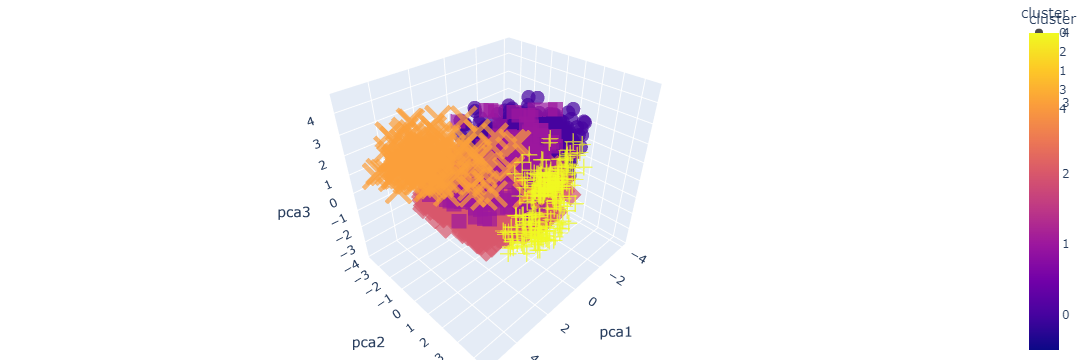

In [97]:
fig = px.scatter_3d(pca_df, x='pca1', y='pca2', z='pca3',
                    color='cluster',
                    symbol='cluster',
                    size_max=18, opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

Some cluster seems to overlap each other, this issue will be solved by auto encoders

## 5. APPLY AUTOENCODERS (PERFORM DIMENSIONALITY REDUCTION USING AUTOENCODERS)

* auto encoders are a type of Artificial Neural Network that are used to perform data encoding or representation learning
* auto encoders use the input and give the same output
* auto encoders works by adding a bottle neck in network
* this bottleneck forces the network to create a compressed (encoded) version of the original input
* auto encoders works well if there is correlation between inputs

In [98]:
sales_df.shape

(2823, 38)

In [99]:
input_df = Input(shape=(38,))
x = Dense(50, activation='relu')(input_df)
x = Dense(500, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer='glorot_uniform')(x)
encoded = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer='glorot_uniform')(encoded)
x = Dense(500, activation='relu', kernel_initializer='glorot_uniform')(x)
decoded = Dense(38, kernel_initializer='glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [101]:
autoencoder.fit(sales_df, sales_df, batch_size=128, epochs=500, verbose=3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [102]:
encoded_df = autoencoder.predict(sales_df_scaled)

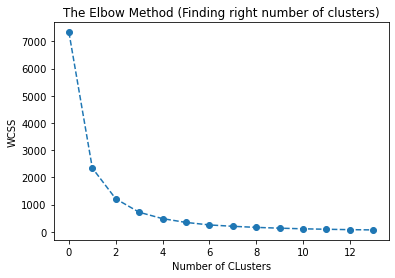

In [104]:
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(encoded_df)
    wcss.append(kmeans.inertia_)  # intertia is the Sum of squared distances of samples to their closest cluster center (WCSS)

plt.plot(wcss, marker='o', linestyle='--')
plt.title('The Elbow Method (Finding right number of clusters)')
plt.xlabel('Number of CLusters')
plt.ylabel('WCSS')
plt.show()

From the above `layer 3` clusters seems best choice

In [105]:
kmeans = KMeans(3)
kmeans.fit(encoded_df)
labels = kmeans.labels_
y = kmeans.fit_predict(sales_df_scaled)

In [106]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  STATUS  MONTH_ID  \
0               30      95.70              2.0  2871.00       1         2   
1               34      81.35              5.0  2765.90       1         5   
2               41      94.74              2.0  3884.34       1         7   
3               45      83.26              6.0  3746.70       1         8   
4               49     100.00             14.0  5205.27       1        10   

   YEAR_ID  MSRP  PRODUCTCODE  PRODUCTLINE_Classic Cars  ...  COUNTRY_Japan  \
0     2003    95            0                         0  ...              0   
1     2003    95            0                         0  ...              0   
2     2003    95            0                         0  ...              0   
3     2003    95            0                         0  ...              0   
4     2003    95            0                         0  ...              0   

   COUNTRY_Norway  COUNTRY_Philippines  COUNTRY_Singapore  COUNTRY_Spain  \
0               0                    0                  0              0   
1               0                    0                  0              0   
2               0                    0                  0              0   
3               0                    0                  0              0   
4               0                    0                  0              0   

   COUNTRY_Sweden  COUNTRY_Switzerland  COUNTRY_UK  COUNTRY_USA  cluster  
0               0                    0           0            1        0  
1               0                    0           0            0        2  
2               0                    0           0            0        0  
3               0                    0           0            1        0  
4               0                    0           0            1        0  

[5 rows x 39 columns]

In [107]:
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=[sales_df.columns])
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers, columns=[sales_df.columns])
cluster_centers

QUANTITYORDERED  PRICEEACH ORDERLINENUMBER        SALES    STATUS  MONTH_ID  \
0       37.947254  95.361741        6.420520  4398.433699  1.013006  7.104769   
1       47.222930  99.799554        5.369427  8293.753248  1.038217  6.770701   
2       30.525741  69.047496        6.649766  2061.682800  1.004680  7.118565   

       YEAR_ID        MSRP PRODUCTCODE PRODUCTLINE_Classic Cars  ...  \
0  2003.806358  115.848988   48.545520                 0.382948  ...   
1  2003.910828  158.184713   26.242038                 0.617834  ...   
2  2003.812793   77.340094   62.788612                 0.265211  ...   

  COUNTRY_Italy COUNTRY_Japan COUNTRY_Norway COUNTRY_Philippines  \
0      0.031792      0.015173       0.030347            0.010116   
1      0.044586      0.019108       0.031847            0.006369   
2      0.048362      0.021841       0.029641            0.008580   

  COUNTRY_Singapore COUNTRY_Spain COUNTRY_Sweden COUNTRY_Switzerland  \
0          0.027457      0.123555       0.022399        1.589595e-02   
1          0.025478      0.108280       0.012739       -1.734723e-18   
2          0.028861      0.120125       0.018721        7.020281e-03   

  COUNTRY_UK COUNTRY_USA  
0   0.051301    0.364884  
1   0.025478    0.407643  
2   0.053822    0.339314  

[3 rows x 38 columns]

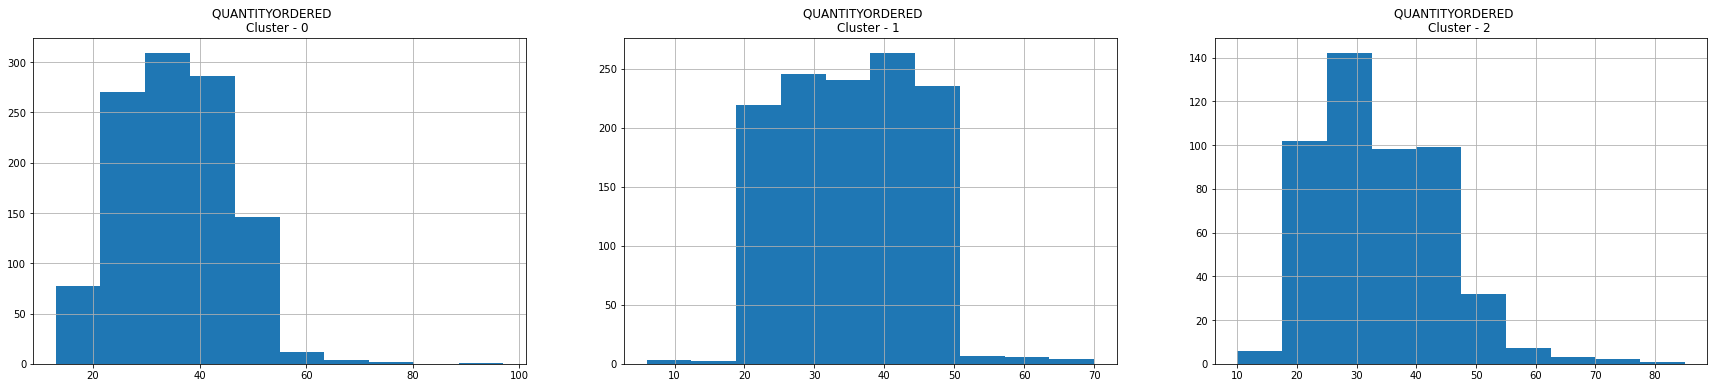

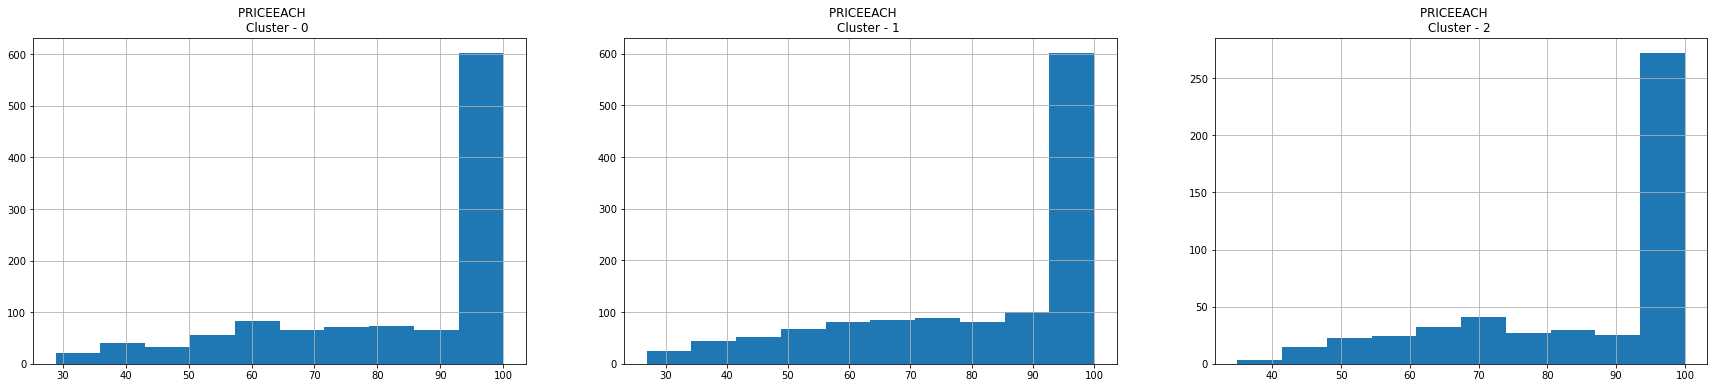

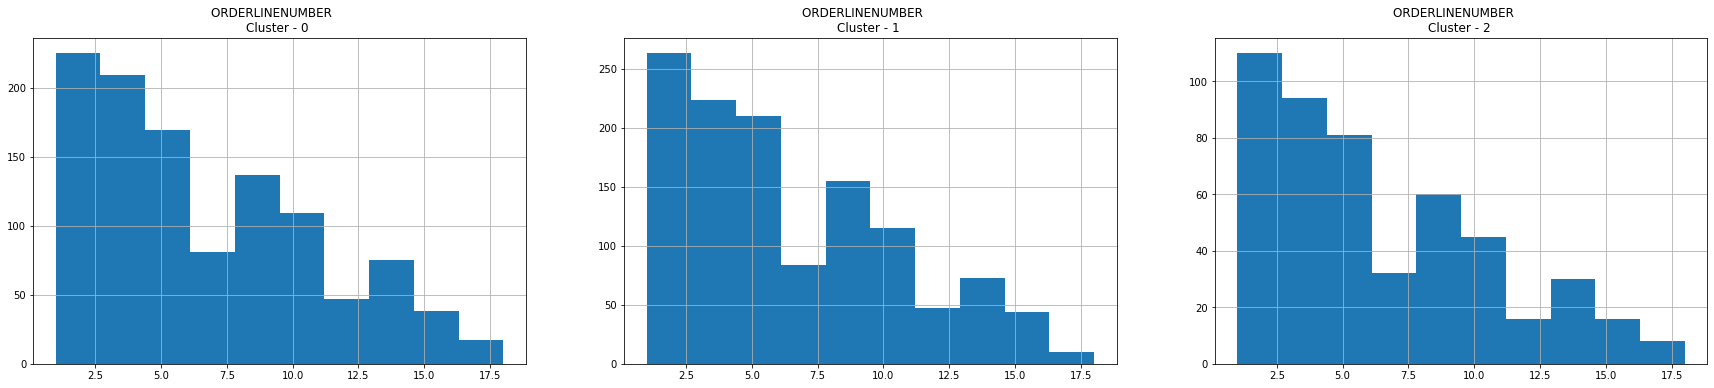

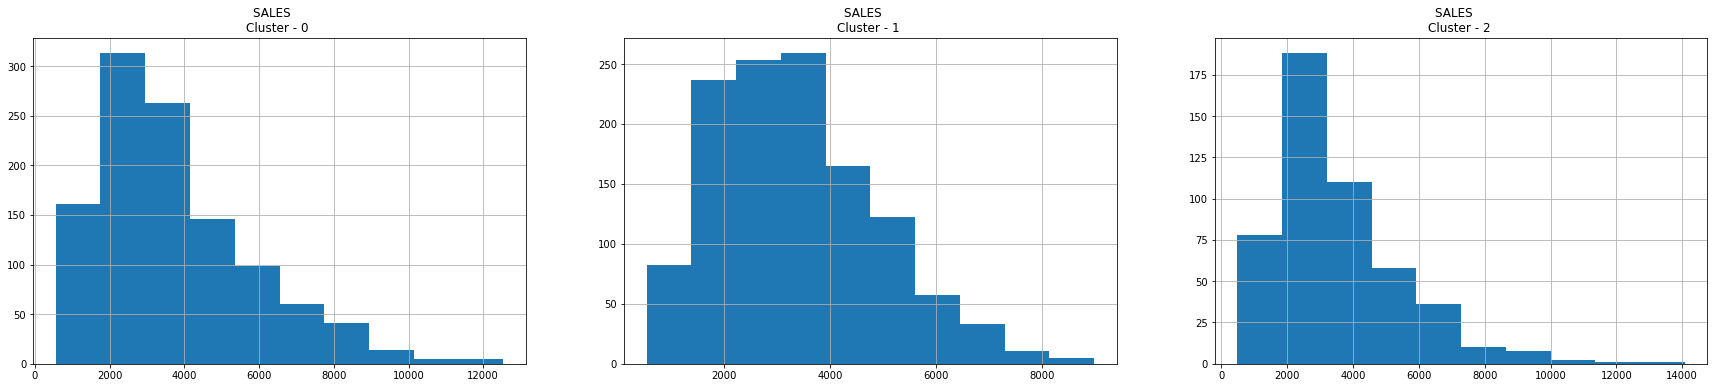

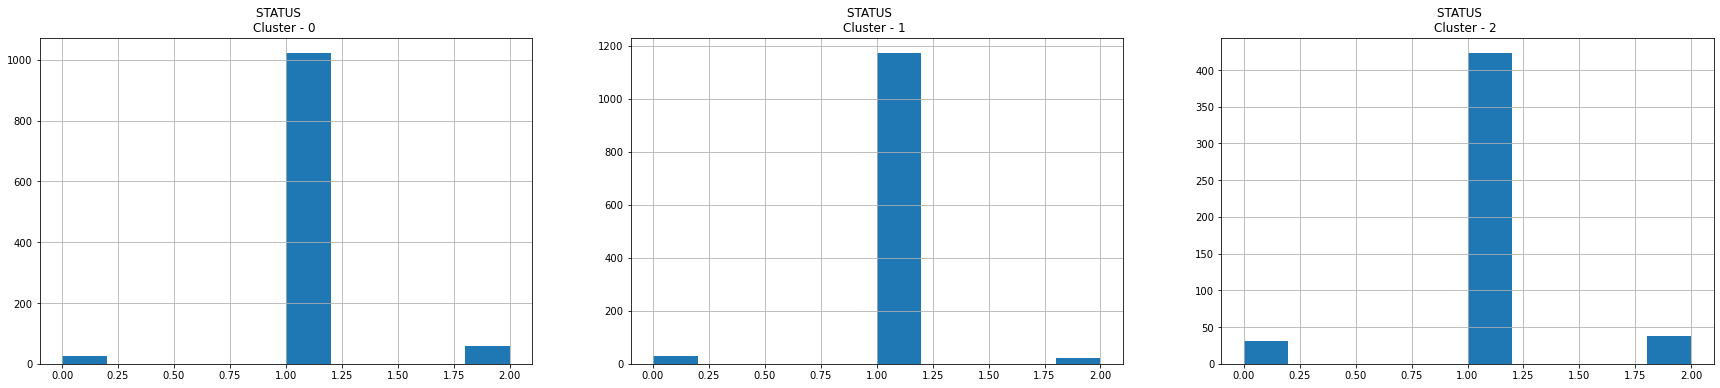

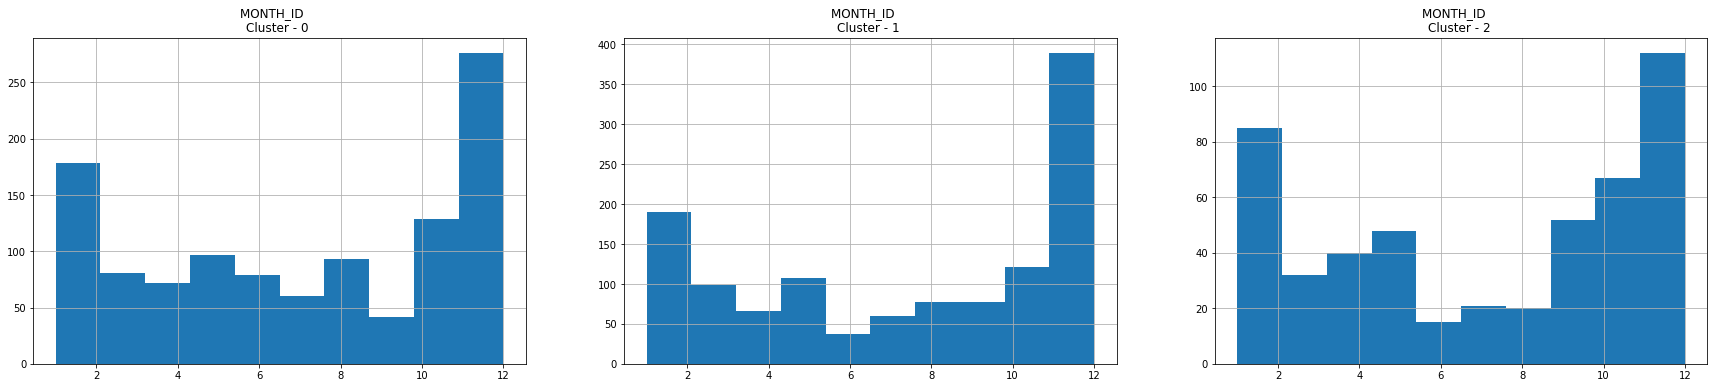

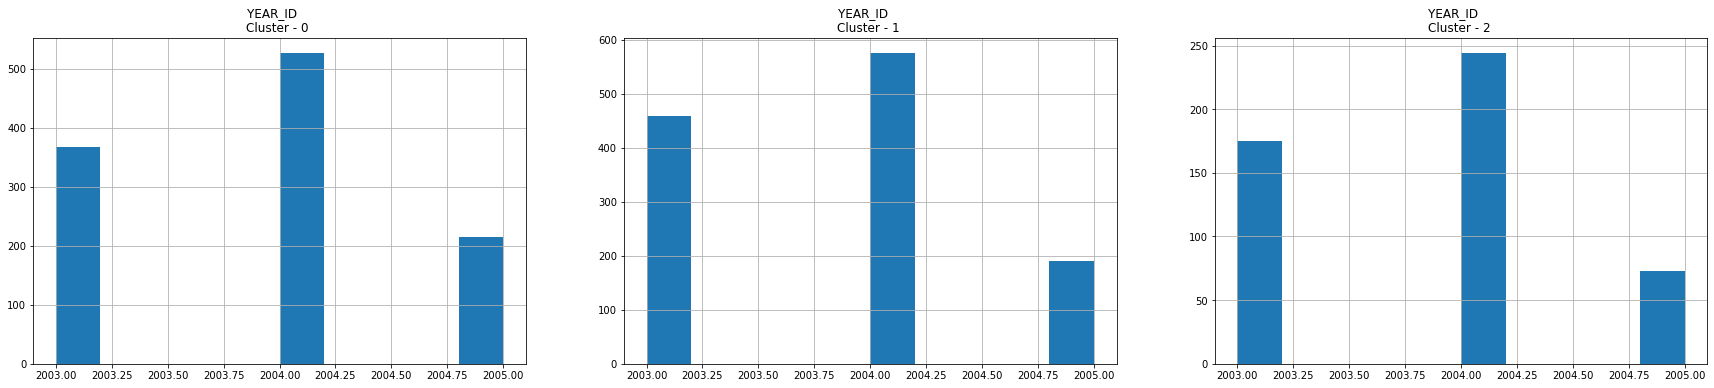

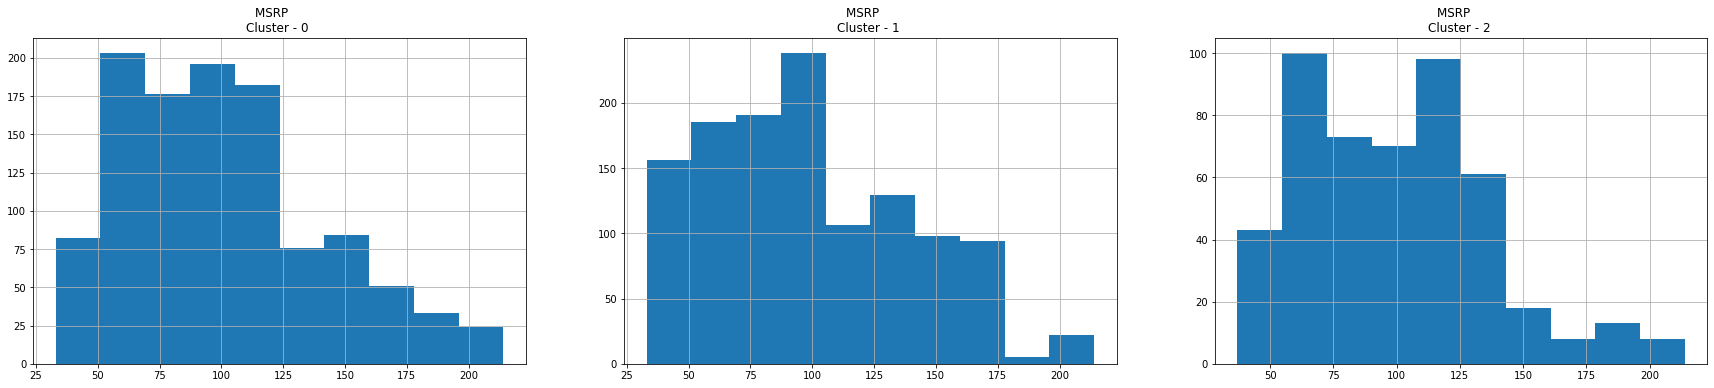

In [108]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
    plt.figure(figsize=(30, 6))
    for j in range(3):
        plt.subplot(1, 3, j+1)
        cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
        cluster[i].hist()
        plt.title('{}    \nCluster - {} '.format(i,j))

plt.show()

### FINAL OBESERVATIONS

* `Cluster 0` - This group represents customers who buy items in high quantity(47), they usually buy items with high prices(99). They bring-in more sales than other clusters. They are mostly active through out the year. They usually buy products corresponding to product code 10-90. They buy products with high mrsp(158).
* `Cluster 1` - This group represents customers who buy items in average quantity(37) and they buy tend to buy high price items(95). They bring-in average sales(4398) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-10 and 90-100.Also they prefer to buy products with high MSRP(115) .
* `Cluster 2` - This group represents customers who buy items in small quantity(30), they tend to buy low price items(69). They correspond to the lowest total sale(2061) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-20 and 100-110 they then to buy products with low MSRP(77).

In [109]:
# Reduce the original data to 3 dimension using PCA for visualize the clusters
pca = PCA(n_components=3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data=prin_comp, columns=['pca1', 'pca2', 'pca3'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis=1)
pca_df.head()

pca1      pca2      pca3  cluster
0 -0.486661 -1.138146  0.785646        0
1 -0.786396 -1.036946  1.374294        2
2  1.429836  0.144162  0.299011        0
3  1.288684 -0.158551 -0.774349        0
4  1.976749 -0.107852 -1.266446        0

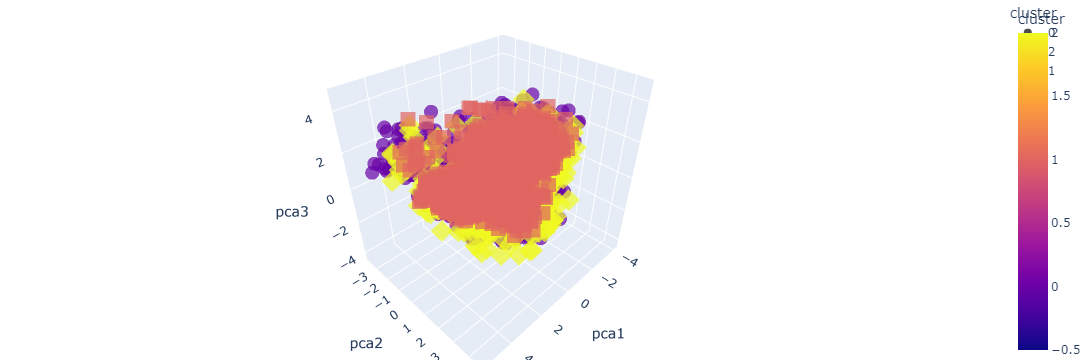

In [111]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x='pca1', y='pca2', z='pca3',
                    color='cluster', symbol='cluster', size_max=10, opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))